In [1]:
import pandas as pd

# Load dataset
data = pd.read_csv("/Users/kimberlycarrington/Visual Studio Code/Data Visualization/olympic_gymnastics.csv")


In [2]:
import ipywidgets as widgets
from IPython.display import display

# Dropdown menu for analysis type selection
dropdown = widgets.Dropdown(
    options=['Event Analysis', 'Geographical Analysis', 'Time Analysis'],
    value='Event Analysis',
    description="Choose one:",
    disabled=False,
)
display(dropdown)

Dropdown(description='Choose one:', options=('Event Analysis', 'Geographical Analysis', 'Time Analysis'), valu…

In [ ]:
# Event Analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode, iqr, shapiro, ttest_ind, mannwhitneyu, kruskal, f_oneway, levene, f
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

def analyze_events(data, selected_events, measure, start_year, end_year):
    
    # Filter data
    filtered_data = data[
        (data['Event'].isin(selected_events)) &
        (data['Year'] >= start_year) &
        (data['Year'] <= end_year) &
        (data['Medal'].notna()) 
    ].drop_duplicates(subset=['ID', 'Event'])

    event_data = {}

    # Filter data for each event
    for event in selected_events:
        
        event_filtered_data = filtered_data[filtered_data['Event'] == event]
        event_filtered_data = event_filtered_data.dropna(subset=[measure])

        if not event_filtered_data.empty:
            event_data[event] = event_filtered_data[measure].tolist()

    # Analyze 1 event
    if len(selected_events) == 1:
        event = selected_events[0]
        values = event_data.get(event, [])

        if not values:
            print(f"No valid data available for {event}")
        else:
            # Parametric statistics
            mean_value = np.mean(values)
            std_dev = np.std(values, ddof=1)
            variance = np.var(values, ddof=1)

            # Non-parametric statistics
            median_value = np.median(values)
            mode_result = mode(values, keepdims=True)
            mode_value = mode_result.mode[0] if mode_result.count[0] > 0 else np.nan
            iqr_value = iqr(values)

            # Print summary
            print(
                "Parametric Measures:\n"
                f"Mean: {mean_value:.2f}\n"
                f"Standard Deviation: {std_dev:.2f}\n"
                f"Variance: {variance:.2f}"
            )
            print(
                "\nNon-Parametric Measures:\n"
                f"Median: {median_value:.2f}\n"
                f"Mode: {mode_value:.2f}\n"
                f"IQR: {iqr_value:.2f}"
            )


            # Plot histogram
            plt.figure(figsize=(10, 6))
            sns.histplot(values, bins=15, kde=True, color='#A594F9')
            plt.axvline(mean_value, color='red', linestyle='--', label='Mean')
            plt.axvline(median_value, color='green', linestyle='-.', label='Median')
            plt.axvline(mode_value, color='#0014FF', linestyle=':', label='Mode')
            plt.title(f'Distribution of {measure} for {event}')
            if measure == "Height":
                plt.xlabel('Height(cm)')
            elif measure == "Weight":
                plt.xlabel('Weight(kg)')
            plt.ylabel('Count')
            plt.legend()
            plt.show()
    
    # Analyze 2 events
    elif len(selected_events) == 2:
        
        # State Hypotheses
        event1, event2 = selected_events
        print("H₀(Null Hypothesis): There is no significant difference in mean", measure, "between", event1, "and", event2)
        print("Hₐ(Alternative Hypothesis): There IS a significant difference in mean", measure, "between", event1, "and", event2)
        

        # Extract Data
        df_events = pd.DataFrame({
            'Event': [],
            'Measure': []
        })

        for event in selected_events:
            temp_df = pd.DataFrame({
                'Event': [event] * len(event_data[event]),
                'Measure': event_data[event]
            })
            df_events = pd.concat([df_events, temp_df], ignore_index=True)

        group1 = df_events[df_events['Event'] == event1]['Measure'].dropna()
        group2 = df_events[df_events['Event'] == event2]['Measure'].dropna()

        # Test for normality
        stat1, p1 = shapiro(group1)
        stat2, p2 = shapiro(group2)

        print(f"\nShapiro-Wilk Test p-values:\n- {event1}: {p1:.4f}\n- {event2}: {p2:.4f}\n")

        # Determine which test to use
        if p1 > 0.05 and p2 > 0.05:
            # Both groups are normally distributed
            print("Both groups appear normal. \nTest Type: Independent Samples t-test.\n")
            stat, p_val = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test (no assumption of equal variance)
            test_used = "Independent Samples t-test"
        else:
            # At least one group is not normal
            print("At least one group is non-normal. \nTest Type: Mann-Whitney U test.\n")
            stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
            test_used = "Mann-Whitney U test"

        # Report Test Results
        print(f"{test_used} Results:")
        print(f"Test Statistic = {stat:.4f}")
        print(f"p-value = {p_val:.4f}")

        # Make Decision
        alpha = 0.05
        if p_val < alpha:
            print("\nDecision: Reject the Null Hypothesis (H₀)")
            print(f"There IS a statistically significant difference in {measure} between {event1} and {event2}.")
        else:
            print("\nDecision: Fail to Reject the Null Hypothesis (H₀)")
            print(f"There is NO statistically significant difference in {measure} between {event1} and {event2}.")

        
        # Box Plot
        plt.figure(figsize=(8,6))
        sns.boxplot(x='Event', y='Measure', data=df_events, color='#A594F9')
        plt.title(f"Comparison of {measure} between {event1} and {event2} (Box Plot)")
        if measure == "Height":
            plt.ylabel('Height(cm)')
        elif measure == "Weight":
            plt.ylabel('Weight(kg)')
    
        plt.show()

        # Overlaid Histograms
        plt.figure(figsize=(8,6))
        for event in selected_events:
            subset = df_events[df_events['Event'] == event]
            sns.histplot(subset['Measure'], kde=True, label=event, element="step", stat="count", common_norm=False)
        plt.title(f"Distribution of {measure} for {event1} and {event2}")
        if measure == "Height":
            plt.xlabel('Height(cm)')
        elif measure == "Weight":
            plt.xlabel('Weight(kg)')
        plt.legend()
        plt.show()

    # Analyze 3 to 5 events
    elif 3 <= len(selected_events) <= 5:
       
        plot_data = pd.DataFrame([
            {'Event': event, measure: value}
            for event, values in event_data.items()
            for value in values
        ])

        # Print Summary 
        print("\nSummary Statistics by Event:")
        summary_stats = plot_data.groupby('Event')[measure].agg(['mean', 'std', 'count'])
        print(summary_stats)

        # Boxplot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Event', y=measure, data=plot_data, color='#A594F9')
        plt.title(f'{measure} Distribution by Event (Box Plot)')
        plt.xlabel('Event')
        if measure == "Height":
            plt.ylabel('Height(cm)')
        elif measure == "Weight":
            plt.ylabel('Weight(kg)')
        plt.show()

        # Hypotheses
        print("\nHypotheses:")
        print("H0: The means of the selected numerical variable are equal across all groups.")
        print("Ha: At least one group has a mean different from the others.")

        

        # Normality Check
        residuals = []
        for event in selected_events:
            group = plot_data[plot_data['Event'] == event][measure]
            group_mean = group.mean()
            residuals.extend(group - group_mean)
        
        stat_resid, p_resid = shapiro(residuals)
        print(f"\nShapiro-Wilk Test for Normality of Residuals:\nStatistic = {stat_resid:.4f}, p-value = {p_resid:.4f}")

        # Homogeneity of variances
        group_values = [plot_data[plot_data['Event'] == event][measure] for event in selected_events]
        stat_levene, p_levene = levene(*group_values)
        print(f"\nLevene's Test for Homogeneity of Variances:\nStatistic = {stat_levene:.4f}, p-value = {p_levene:.4f}")

        # ANOVA Test
        if p_resid > 0.05 and p_levene > 0.05:
            # Normal residuals and equal variances → standard ANOVA
            stat_anova, p_anova = f_oneway(*group_values)
            test_used = "One-way ANOVA (equal variances)"
        else:
            # Non-normal residuals or unequal variances → Kruskal-Wallis
            stat_anova, p_anova = kruskal(*group_values)
            test_used = "Kruskal-Wallis Test (non-parametric)"

        print(f"\n{test_used} Result:\nStatistic = {stat_anova:.4f}, p-value = {p_anova:.4f}")

        
        alpha = 0.05
        if p_anova < alpha:
            print(f"\nSince p-value ({p_anova:.4f}) < alpha ({alpha}), we reject the null hypothesis.")
            print("Conclusion: At least one group mean is significantly different.")
        else:
            print(f"\nSince p-value ({p_anova:.4f}) >= alpha ({alpha}), we fail to reject the null hypothesis.")
            print("Conclusion: No significant difference between group means.")


        # F distribution
        if test_used.startswith("One-way ANOVA"):
            x = np.linspace(0, 10, 500)
            dfn = len(selected_events) - 1  # degrees of freedom numerator
            dfd = plot_data.shape[0] - len(selected_events)  # degrees of freedom denominator
            alpha = 0.05  # significance level
            critical_value = f.ppf(1 - alpha, dfn, dfd)
            plt.figure(figsize=(10, 6))
            plt.plot(x, f.pdf(x, dfn, dfd), label=f'F-distribution (df1={dfn}, df2={dfd})')
            x_shade = np.linspace(critical_value, x[-1], 100)
            plt.fill_between(x_shade, f.pdf(x_shade, dfn, dfd), color='red', alpha=0.3, label='Rejection Region')
            plt.axvline(stat_anova, color='red', linestyle='--', label=f'F-statistic = {stat_anova:.2f}')
            plt.title('F-Distribution with Test Statistic')
            plt.xlabel('F Value')
            plt.ylabel('Density')
            plt.legend()
            plt.show()

        # Posthoc Analysis
        if p_anova < 0.05:
            print("\nPosthoc Analysis (since p < 0.05):")
            if test_used.startswith("One-way ANOVA"):
                # Tukey's HSD
                tukey = pairwise_tukeyhsd(endog=plot_data[measure], groups=plot_data['Event'], alpha=0.05)
                print("\nTukey's HSD results:")
                print(tukey.summary())
            else:
                # Dunn’s Test
                dunn = sp.posthoc_dunn(
                    [plot_data[plot_data['Event'] == event][measure].values for event in selected_events],
                    p_adjust='bonferroni'
                )
                dunn.index = selected_events
                dunn.columns = selected_events
                print("\nDunn's Test results (p-values):")
                print(dunn)

        # Histograms
        plt.figure(figsize=(10, 6))
        for event in plot_data['Event'].unique():
            subset = plot_data[plot_data['Event'] == event]
            sns.histplot(subset[measure], kde=True, label=event, element="step", stat='count')
        plt.title(f'Distribution of {measure} Across Events')
        if measure == "Height":
            plt.xlabel('Height(cm)')
        elif measure == "Weight":
            plt.xlabel('Weight(kg)')
        plt.ylabel('Count')
        plt.legend()
        plt.show()

    else:
        pass

In [ ]:
# Time Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def time_analysis(data, measure, medalists_only, start_year, end_year):
    # Filter data
    filtered_data = data[
        (data['Year'] >= start_year) &
        (data['Year'] <= end_year)
    ]
    if medalists_only:
        filtered_data = filtered_data[filtered_data['Medal'].notna()]

    if filtered_data.empty:
        print("No data available for the selected filters.")
        return

    print(f"Analyzing {measure} from {start_year} to {end_year}")
    

   
    if measure == 'Athletes':
        # Count number of athletes each year
        grouped_data = filtered_data.groupby('Year').size().reset_index(name='Athletes')
    else:
        # Compute mean of the selected measure each year
        grouped_data = filtered_data.groupby('Year')[measure].mean().reset_index()

    # Convert weight from kg to lbs
    plot_measure = measure
    if measure == 'Weight':
        grouped_data['Weight'] = grouped_data['Weight'] * 2.20462 
        plot_measure = 'Weight (lbs)'
    elif measure == 'Height':
        plot_measure = 'Height (cm)'

    # Summary statistics
    y_col = grouped_data.columns[1]
    min_row = grouped_data.loc[grouped_data[y_col].idxmin()]
    max_row = grouped_data.loc[grouped_data[y_col].idxmax()]
    overall_mean = grouped_data[y_col].mean()

    print("\nSummary:")
    print(f"Lowest average {plot_measure}: {min_row[y_col]:.1f} in {int(min_row['Year'])}")
    print(f"Highest average {plot_measure}: {max_row[y_col]:.1f} in {int(max_row['Year'])}")
    print(f"Overall average {plot_measure}: {overall_mean:.1f}")


    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Year', y=measure, data=grouped_data, marker='o', color='#A594F9')
    plt.title(f'Line Graph Showing {measure} Over Time')
    plt.xlabel('Year')
    plt.ylabel(f'Mean {plot_measure}' if measure != 'Athletes' else 'Number of Athletes')
    plt.grid(True)
    plt.show()

    

In [5]:
# Geographic Analysis

import plotly.express as px
import pandas as pd

def make_choropleth_map(df, measure, start_year, end_year):
    # Filter by year
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

    if measure == 'Medals':
        df = df[df['Medal'].notna()]  # keep only medalists

    # Count by country
    if measure == 'Athletes':
        # Count unique athlete IDs per country
        counts = df.groupby('Country')['ID'].nunique().reset_index(name='Count')
    else:
        # Count medals (still row-based, assuming each row = a medalist event)
        counts = df.groupby('Country').size().reset_index(name='Count')

    counts.columns = ['Country', 'Count']

    # Convert country names to ISO-3 if needed
    import pycountry
    def get_iso3(name):
        try:
            return pycountry.countries.lookup(name).alpha_3
        except:
            return None
    counts['iso_alpha'] = counts['Country'].apply(get_iso3)
    counts = counts.dropna(subset=['iso_alpha'])

    # Plot
    fig = px.choropleth(
        counts,
        locations='iso_alpha',
        color='Count',
        hover_name='Country',
        color_continuous_scale='Purp',
        labels={'Count': f'Number of {measure}'},
        title=f'{measure} by Country ({start_year}-{end_year})'
    )
    fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
    fig.show()


Time Analysis


Checkbox(value=False, description='Medalists Only', indent=False)

Button(description='Evaluate', icon='check', style=ButtonStyle(), tooltip='Click me')

Analyzing Age from 1952 to 2016

Summary:
Lowest average Age: 16.3 in 1980
Highest average Age: 23.1 in 1952
Overall average Age: 19.0


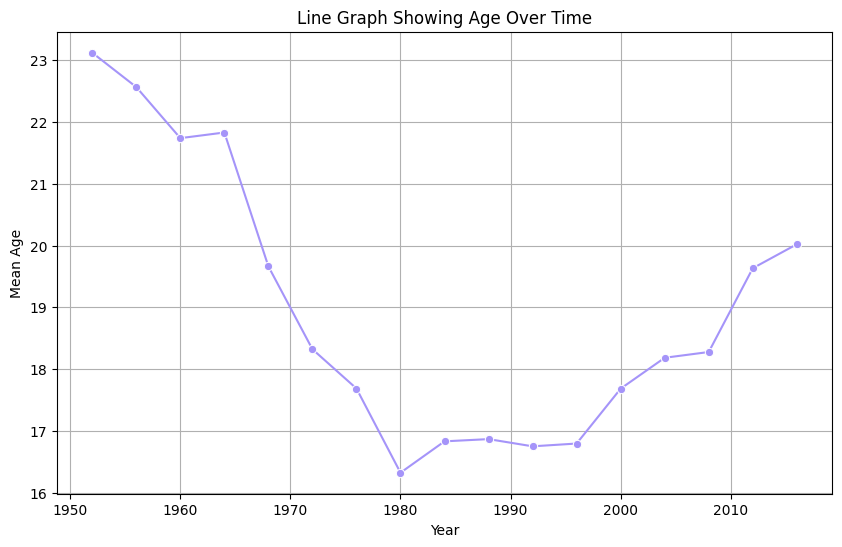

Analyzing Height from 1952 to 2016

Summary:
Lowest average Height (cm): 151.8 in 1996
Highest average Height (cm): 160.1 in 1952
Overall average Height (cm): 156.2


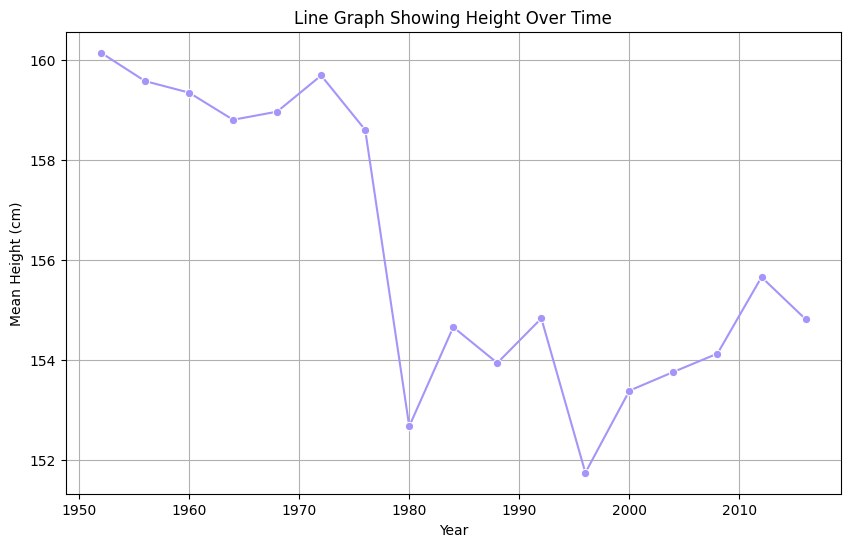

Analyzing Weight from 1952 to 2016

Summary:
Lowest average Weight (lbs): 91.5 in 1980
Highest average Weight (lbs): 120.8 in 1956
Overall average Weight (lbs): 105.7


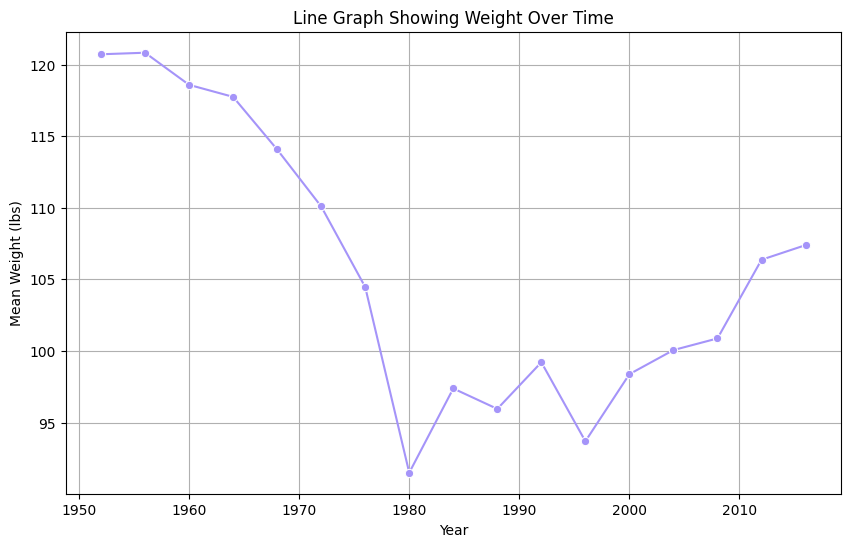

In [ ]:
analysis_type = dropdown.value
print(analysis_type)

events = []
earliest_year = 1952
latest_year = 2016
measure = None
medalists_only = True

if analysis_type == "Event Analysis":
    print("\n Select event(s):")
    
    vault = widgets.Checkbox(
        value=False,
        description='Vault',
        disabled=False,
        indent=False
    )
    uneven_bars = widgets.Checkbox(
        value=False,
        description='Uneven Bars',
        disabled=False,
        indent=False
    )
    balance_beam = widgets.Checkbox(
        value=False,
        description='Balance Beam',
        disabled=False,
        indent=False
    )
    floor = widgets.Checkbox(
        value=False,
        description='Floor',
        disabled=False,
        indent=False
    )
    all_around = widgets.Checkbox(
        value=False,
        description='Individual All-Around',
        disabled=False,
        indent=False
    )
    display(vault)
    display(uneven_bars)
    display(balance_beam)
    display(floor)
    display(all_around)

    # select weight or height, dropdown or menu
    measure_dropdown = widgets.Dropdown(
        options=['Height', 'Weight'],
        value='Height',
        description='Pick one:',
        disabled=False,
    )
    # display dropdown
    display(measure_dropdown)
    # save selected variable

    # narrow down years, int range slider
    years = widgets.IntRangeSlider(
        value=[1952, 2016],
        min=1952,
        max=2016,
        step=4,
        description='Years:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )
    # display int slider
    display(years)
    

    button = widgets.Button(
        description='Evaluate',
        disabled=False,
        button_style='', 
        tooltip='Click me',
        icon='check' 
    )

    def on_button_click(b):
        global events, measure, earliest_year, latest_year
        if vault.value: 
            events.append("Vault")
        if uneven_bars.value:
            events.append("Uneven Bars")
        if balance_beam.value:
            events.append("Beam")
        if floor.value:
            events.append("Floor")
        if all_around.value:
            events.append("All-Around")
        measure = measure_dropdown.value
        earliest_year, latest_year = years.value
        analyze_events(data, events, measure, earliest_year, latest_year)
        


    button.on_click(on_button_click)
    display(button)

elif analysis_type == "Geographical Analysis":
    
    # select number of medals or athletes, selector
    measure_dropdown = widgets.Dropdown(
        options=['Medals', 'Athletes'],
        value='Medals',
        description='Pick one:',
        disabled=False,
    )
    # display dropdown
    display(measure_dropdown)
   
    # select year or narrow down range, int slider
    years = widgets.IntRangeSlider(
        value=[1952, 2016],
        min=1952,
        max=2016,
        step=4,
        description='Years:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )
    # display slider
    display(years)

    button = widgets.Button(
        description='Evaluate',
        disabled=False,
        button_style='', 
        tooltip='Click me',
        icon='check' 
    )

    def on_button_click(b):
        global measure, earliest_year, latest_year
        measure = measure_dropdown.value
        earliest_year, latest_year = years.value
        make_choropleth_map(data, measure, earliest_year, latest_year)

    button.on_click(on_button_click)
    display(button)

elif analysis_type == "Time Analysis":
    
    measure_dropdown = widgets.Dropdown(
        description='Number:',
        disabled=False,
    )

    checkbox_medals = widgets.Checkbox(
        value=False,
        description='Medalists Only',
        disabled=False,
        indent=False
    )
    # display checbox
    display(checkbox_medals)

    dropdown_container = widgets.VBox()

    button = widgets.Button(
        description='Evaluate',
        disabled=False,
        button_style='',
        tooltip='Click me',
        icon='check'
    )

    def on_button_click(b):
        global measure, earliest_year, latest_year, medalists_only
        measure = measure_dropdown.value
        earliest_year, latest_year = years.value
        medalists_only = checkbox_medals.value
        time_analysis(data, measure, medalists_only, 1952, 2016)
        

    def show_options(change):
        # Update dropdown options based on checkbox
        if checkbox_medals.value:
            measure_dropdown.options = ['Age', 'Height', 'Weight']
        else:
            measure_dropdown.options = ['Age', 'Height', 'Weight', 'Athletes']
        measure_dropdown.value = measure_dropdown.options[0]  # Set default value
        # Replace contents of the container (no duplicates)
        dropdown_container.children = [measure_dropdown]

    checkbox_medals.observe(show_options, names='value')
    button.on_click(on_button_click)
    show_options(None)
    display(dropdown_container)
    display(button)

    